In [325]:
import os
from collections import defaultdict
from urllib.parse import urljoin

import requests
from bokeh.io import output_notebook, show
from bokeh.models import NumeralTickFormatter
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

# https://docs.transifex.com/api/
TRANSIFEX_API_URL = "https://www.transifex.com/api/2/"
# https://www.transifex.com/user/settings/api/
TRANSIFEX_API_TOKEN = os.environ.get("TRANSIFEX_API_TOKEN")

PROJECT_NAME = "python-newest" # Lastest version of Python (Master branch on Github)
PROJECT_LANG = "pt_BR"

# Configure bokeh to work with jupyter
output_notebook()

Loading BokehJS ...

In [215]:
def request(url):
    response = requests.get(urljoin(TRANSIFEX_API_URL, url), auth=("api", TRANSIFEX_API_TOKEN))
    
    if not response.ok:
        raise Exception(f"Error, status_code={response.status_code}, {url}")
    return response.json()

In [216]:
# Request all resources available on Transifex
resources = request(f"project/{PROJECT_NAME}/resources/")
resources = [resource["slug"] for resource in resources]

In [223]:
# Retrieve statistics from every resource
stats = defaultdict(lambda: {"translated_words": 0, "words": 0})
for resource in resources:
    stat = request(f"project/{PROJECT_NAME}/resource/{resource}/stats/{PROJECT_LANG}/")
    
    # Group stats considering the first part of slug.
    # Transform "c-api--abstract" and "c-api--allocation" into "c-api".
    resource = resource.split('--')[0]
    
    stats[resource]["translated_words"] += stat["translated_words"]
    stats[resource]["words"] += stat["translated_words"] + stat["untranslated_words"]
    
stats = {key: stats[key] for key in sorted(stats.keys(), reverse=True)}

In [379]:
# Configure nice colors for the chart
required_resources = ["bugs", "howto", "library"]

color = lambda resource, color1, color2: color1 if resource in required_resources else color2

fill_palette = [color(resource, "gold", "dodgerblue") for resource in y_resources]
line_palette = [color(resource, "goldenrod", "royalblue") for resource in y_resources]
    
fill_color_map = factor_cmap("y", palette=fill_palette, factors=y_resources)
line_color_map = factor_cmap("y", palette=line_palette, factors=y_resources)

In [385]:
plot = figure(
    title="Porcentagem da documentação traduzida por seção",
    y_range=y_resources,
    plot_width=900,
    plot_height=600,
    y_axis_label="Seção da documentação",
    x_axis_label="Porcentagem traduzida",
)

y_resources = list(stats.keys())
x_translated = [s["translated_words"]/s["words"] for s in stats.values()]

plot.hbar(
    y=y_resources,
    right=x_translated,
    height=0.7,
    fill_color=fill_color_map,
    line_color=line_color_map,
)
plot.xaxis.formatter = NumeralTickFormatter(format="0%")
plot.yaxis.major_label_text_font_size = "15pt"
plot.title.text_font_size = "20pt"

percentage_per_resource_plot = plot

In [386]:
plot = figure(
    title="Palavras não traduzidas por seção",
    y_range=y_resources,
    plot_width=900,
    plot_height=600,
    y_axis_label="Seção da documentação",
    x_axis_label="Palavras não traduzidas",
)

y_resources = list(stats.keys())
x_words = [s['words']-s['translated_words'] for s in stats.values()]

plot.hbar(
    y=y_resources,
    right=x_words,
    height=0.7,
    fill_color=fill_color_map,
    line_color=line_color_map,
)
plot.xaxis.formatter = NumeralTickFormatter(format='0 a')
plot.yaxis.major_label_text_font_size = "15pt"
plot.title.text_font_size = "20pt"

words_not_translated_plot = plot

In [387]:
show(percentage_per_resource_plot)
show(words_not_translated_plot)

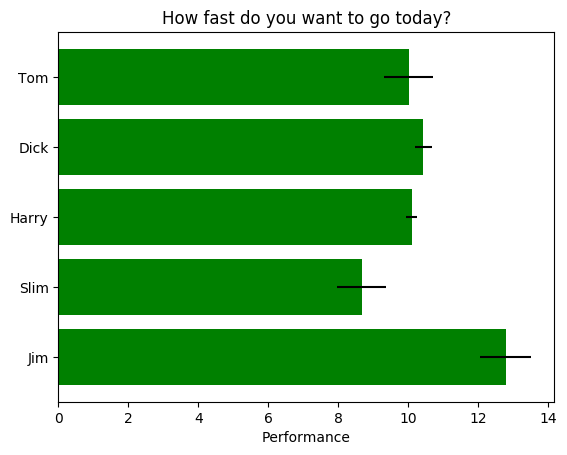

In [388]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
y_pos = np.arange(len(people))
performance = 3 + 10 * np.random.rand(len(people))
error = np.random.rand(len(people))

ax.barh(y_pos, performance, xerr=error, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('How fast do you want to go today?')

plt.show()